In [6]:
import os
import pandas as pd
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
#pd.show_versions(as_json=False)

threshold = 1000

In [7]:
# Load Data
def load_raw(fn):
    datapath = os.path.join('../csse_covid_19_data/csse_covid_19_time_series/', fn)

    #datapath = '../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    
    raw = pd.read_csv(datapath)
    del raw['Lat']
    del raw['Long']
    raw= raw.replace('Mainland China','China')
    return raw

raw = load_raw('time_series_covid19_confirmed_global.csv')
raw_deaths = load_raw('time_series_covid19_deaths_global.csv')

raw


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,170,174,237,273,281,299,349,367,423,444
1,NaN,Albania,0,0,0,0,0,0,0,0,...,223,243,259,277,304,333,361,377,383,400
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,584,716,847,986,1171,1251,1320,1423,1468,1572
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,370,376,390,428,439,466,501,525,545,564
4,NaN,Angola,0,0,0,0,0,0,0,0,...,7,7,8,8,8,10,14,16,17,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Falkland Islands (Malvinas),United Kingdom,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,2,5
259,Saint Pierre and Miquelon,France,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
260,NaN,South Sudan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,2,2
261,NaN,Western Sahara,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,4,4,4


In [8]:
# Shift all the series
def shift(df, threshold=1000):
    maxDate = max(df.index)    
    for c in df.columns:
        for i,a in enumerate(df[c]):        
            if i==0 and a>threshold:
                df[c]=df[c].shift(4) # hack to push out china
                break
            if a>=threshold:
                df[c]=df[c].shift(-i)            
                break
    df=df.reset_index(drop=True)
    #del df['China']
    return df


In [9]:
%matplotlib inline
from math import pow


def plotdataframe(df, logy=False, legend=True):
    plt.rcParams["figure.figsize"] = [10, 10]
    fig, ax = plt.subplots()
    markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
    for c,m in zip(df,markers):
        df[c].plot(logy=logy, marker=m, fontsize=12,ax=ax, linewidth=2.5)
    
    font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
    legend and ax.legend(prop=font)

    return ax

def plotdataframe_point(df, logy=False, legend=True, legend_loc='best', title=None):
    plt.rcParams["figure.figsize"] = [10, 10]
    fig, ax = plt.subplots()
    markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
    lines = []
    legendcols = []
    maxX = max([max([x for c in df for (x,y) in zip(df.index,df[c]) if y>0])])
    #print(maxX)
    for c,m in zip(df,markers):
        pts = list([x for (x,y) in zip(df.index,df[c]) if y>0])
        ys = list([x for x in df[c] if x>0])
        if len(pts)<=1:
            continue
        legendcols.append(c)
        df[c].plot(logy=logy, marker=m, fontsize=12,ax=ax, linewidth=1, color='#999999')
        
        offset = (10,0)
        #print([pts[0],pts[-1]],[ys[0],ys[-1]])
        l,=ax.plot([pts[0],pts[-1]],[ys[0],ys[-1]], linewidth=2.5, marker=m)
        lines.append(l)
        growth = round((pow(ys[-1]/ys[0],1.0/(pts[-1]-pts[0]))-1)*100)
        
        alignment = 'left'
        if pts[-1]>0.9*maxX:
            offset = (0,5)
            alignment = 'center'
        ax.annotate('{} ({}%)'.format(c,growth), xy=(pts[-1],ys[-1]), xytext=offset, textcoords='offset points', ha=alignment, size=12)
    
    if logy:
        ax.get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
    legend and ax.legend(lines,legendcols,prop=font, loc=legend_loc)

    title and ax.set_title(title, size=14)
    return ax

def save_figure(maxDate, filename):
    savedir = os.path.join('data',maxDate.strftime('%Y%m%d'))
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
    plt.savefig(os.path.join(savedir,filename))


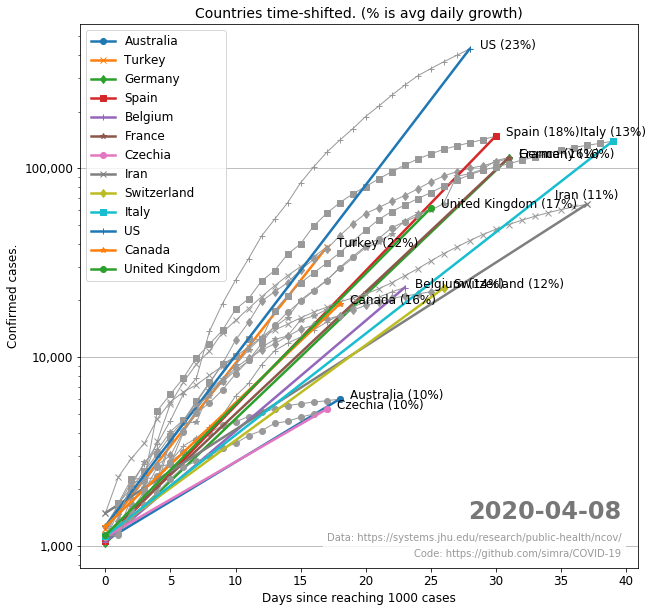

In [10]:
df=raw.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

threshold = 1000
del df['China']
columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['Canada','Australia','Czechia']))
#print(columns)
#df = df[[c for c in df.columns if df[c].max()>12000 or c in ['Canada','US', 'Australia','Czechia']]]
df=df[columnsToSelect]
maxDate = max(df.index)
df = shift(df)

ax=plotdataframe_point(df, logy=True, title='Countries time-shifted. (% is avg daily growth)')
ax.set_xlabel("Days since reaching {} cases".format(threshold), size=12)
ax.set_ylabel("Confirmed cases." , size=12)
ax.grid(axis='y')
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'1_countryshift.png')


Removed:  ['Albania', 'Andorra', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Bahamas', 'Bahrain', 'Barbados', 'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brunei', 'Bulgaria', 'Burma', 'Cabo Verde', 'Central African Republic', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Fiji', 'Finland', 'Gabon', 'Gambia', 'Georgia', 'Grenada', 'Guinea-Bissau', 'Guyana', 'Holy See', 'Honduras', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Jamaica', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'MS Zaandam', 'Maldives', 'Malta', 'Mauritania', 'Mauritius', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Namibia', 'New Zealand', 'Nicaragua', 'North Macedonia', 'Norway', 'Oman', 'Panama', 'Papua New Guinea', 'Paragua

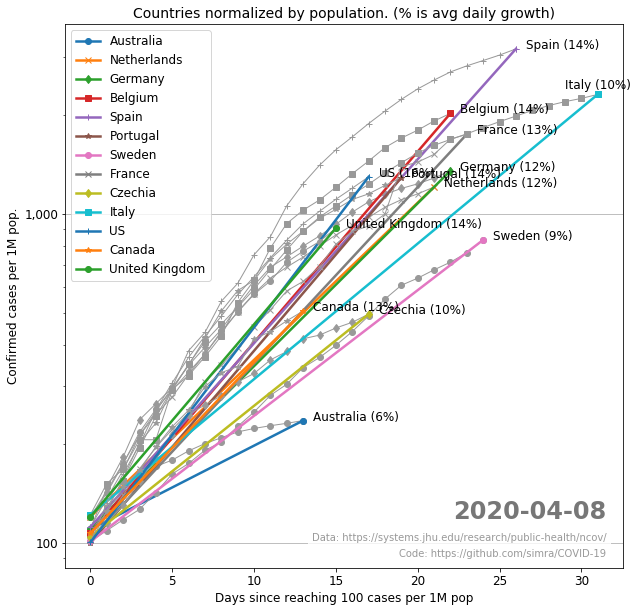

In [45]:
# Try normalizing by population
# https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv
wpp = pd.read_csv('../wpp/WPP2019_TotalPopulationBySex.csv')
wpp=wpp[(wpp['Time']==2020) & (wpp['Variant']=='Medium')]
wpp = dict(zip(wpp['Location'],wpp['PopTotal']))
wpp['Iran']=wpp['Iran (Islamic Republic of)']
wpp['US']=wpp['United States of America']
wpp['Korea, South']= wpp['Republic of Korea']
wpp['Russia'] = wpp['Russian Federation']

df=raw.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

columnsRemoved = [c for c in df.columns if c not in wpp or wpp[c]<10000]
columnsFiltered = [c for c in df.columns if c in wpp and wpp[c]>=10000]
df = df[columnsFiltered]
print("Removed: ",columnsRemoved)

#df = df[[c for c in df.columns if df[c].max()>10000 or c in ['Canada','US', 'Australia', 'Czechia']]]
for c in df.columns:
    df[c] = df[c]*1000/wpp[c]
#df = df[[c for c in df.columns if df[c].max()>1000 or c in ['Canada','US', 'Australia', 'Czechia']]]
columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['Canada','US','Australia','Czechia']))
df=df[columnsToSelect]


#plotdataframe(df, logy=True)
maxDate = max(df.index)
threshold = 100
df= shift(df,threshold=threshold)

ax=plotdataframe_point(df, logy=True, title="Countries normalized by population. (% is avg daily growth)")
ax.set_xlabel("Days since reaching {} cases per 1M pop".format(threshold), size=12)
ax.set_ylabel("Confirmed cases per 1M pop." , size=12)
ax.grid(axis='y')
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'2_countryshift_norm.png')

#wpp

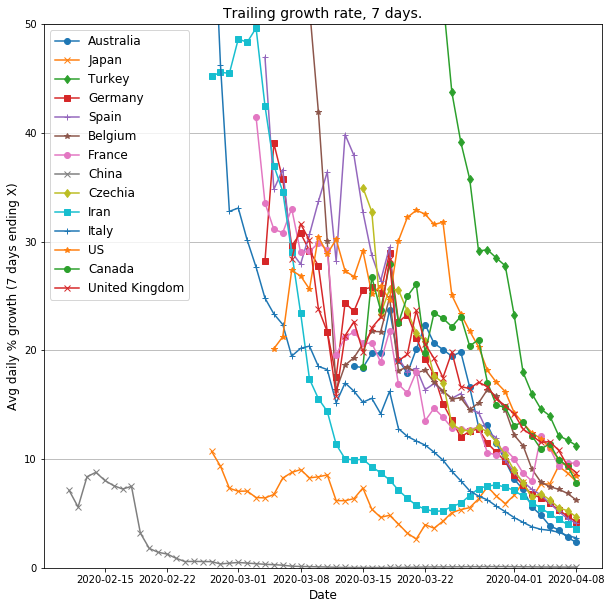

In [41]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>20000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']

columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['Canada','Australia','Japan','Czechia']))
df = df[columnsToSelect]

maxDate=max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
for c,m in zip(df.columns,markers):
    growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    #if c=='France':
    #    print(list(df[c]))
    ax.plot(df.index[20:], growth[c], marker=m)

    
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid(axis='y') 
#ax.yaxis.set_label_position("right")
ax.set_ylim([0,50])
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Avg daily % growth (7 days ending X)', size=12)
ax.set_title('Trailing growth rate, 7 days.', size=14)
ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
save_figure(maxDate,'3_growth.png')

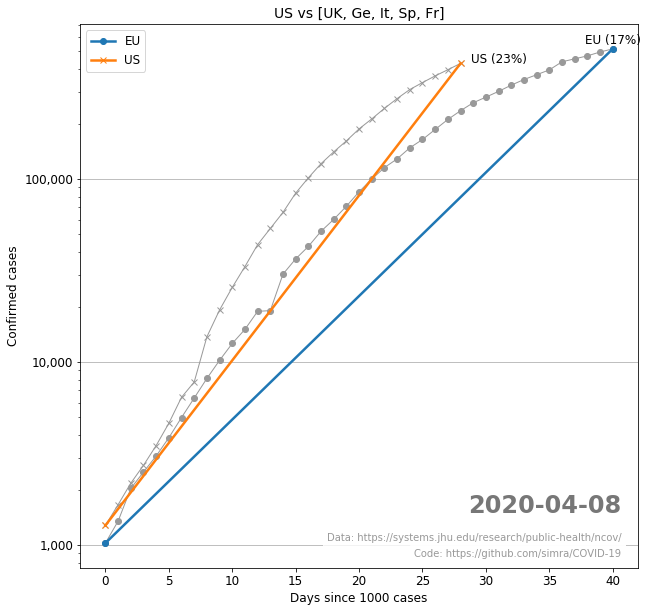

In [13]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>4000)]
df = df[df.index.isin(['US','France','Germany','Italy','Spain', 'UK'])]
df = df.groupby(df.index=='US').sum()
df.index = ['US' if c else 'EU' for c in df.index]
df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate = max(df.index)
threshold = 1000
df=shift(df,threshold=threshold)
ax=plotdataframe_point(df, logy=True)

ax.set_xlabel('Days since {} cases'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.grid(axis='y')
ax.set_title('US vs [UK, Ge, It, Sp, Fr]', size=14)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '6_euus.png')

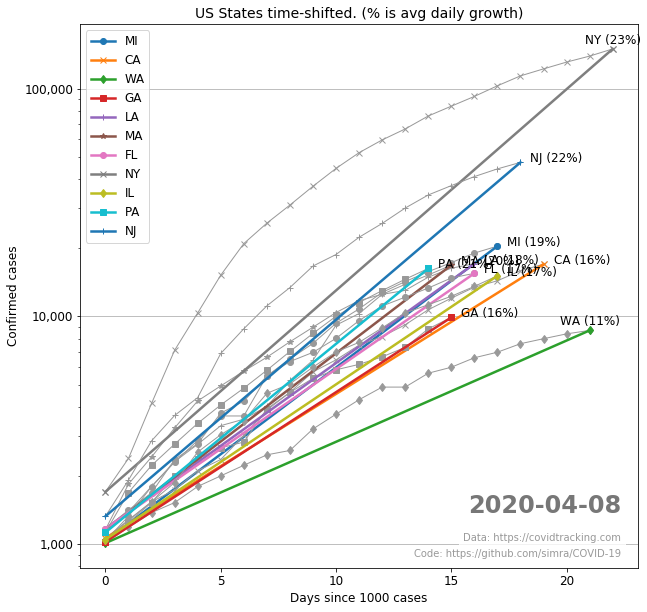

In [48]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
df = covidtracking.pivot(index='date',columns='state', values='positive')
df = df.fillna(0)
columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['WA']))
#df = df[[c for c in df.columns if df[c].max()>5000 or c=='WA']]
df = df[columnsToSelect]

shift_threshold = 1000
df = shift(df, threshold=shift_threshold)

ax=plotdataframe_point(df, logy=True, title='US States time-shifted. (% is avg daily growth)')


ax.set_xlabel('Days since {} cases'.format(shift_threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.grid(axis='y')
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.05, 'Data: https://covidtracking.com', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate,'9_usstates.png')


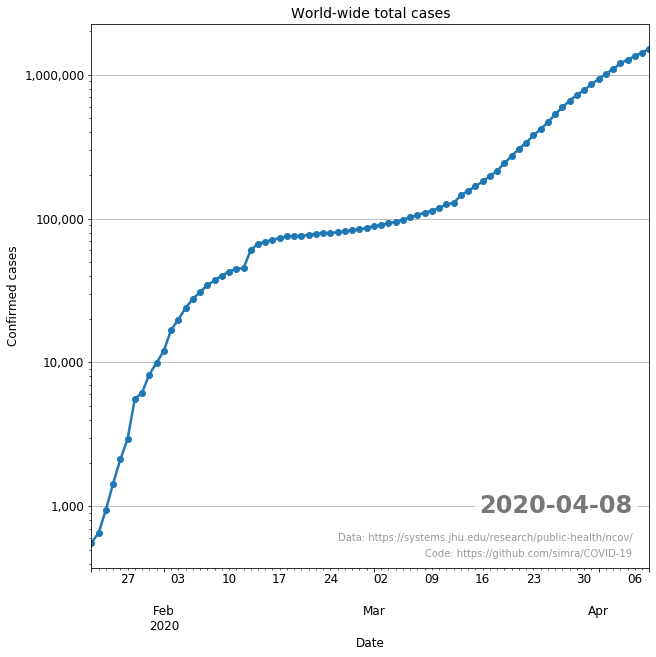

In [15]:
df=raw.groupby(lambda x: True).sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>4000)]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
df.index = ['World']
df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
maxDate = max(df.index)
#del df['Cruise Ship']
#df=shift(df)
df
ax=plotdataframe(df, logy=True, legend=False)
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel('Date', size=12)
ax.set_title('World-wide total cases', size=14)
ax.grid(axis='y')
ax.set_ylabel('Confirmed cases', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate,'7_world.png')

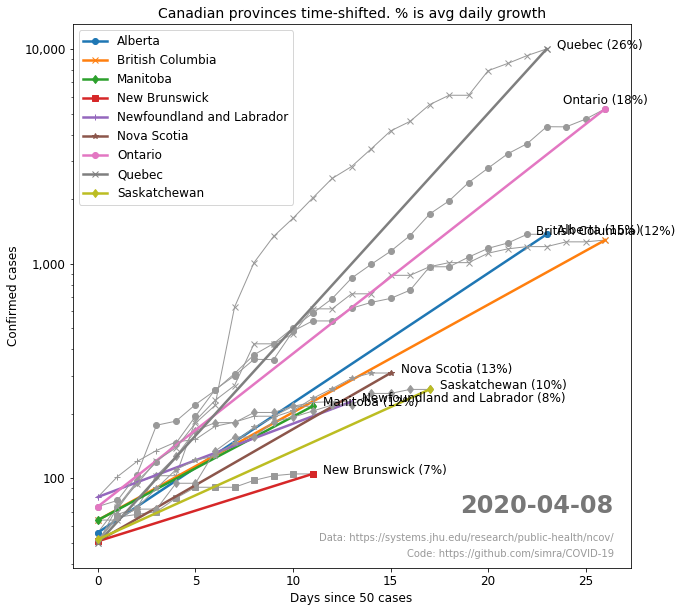

In [16]:
df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
threshold=50
df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Province/State']=df.index
df=df.melt(id_vars='Province/State',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province/State')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

maxDate = max(df.index)
df=shift(df,threshold)
df
ax=plotdataframe_point(df, logy=True, legend_loc='upper left', title='Canadian provinces time-shifted. % is avg daily growth')
ax.set_xlabel('Days since {} cases'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '8_canada.png')

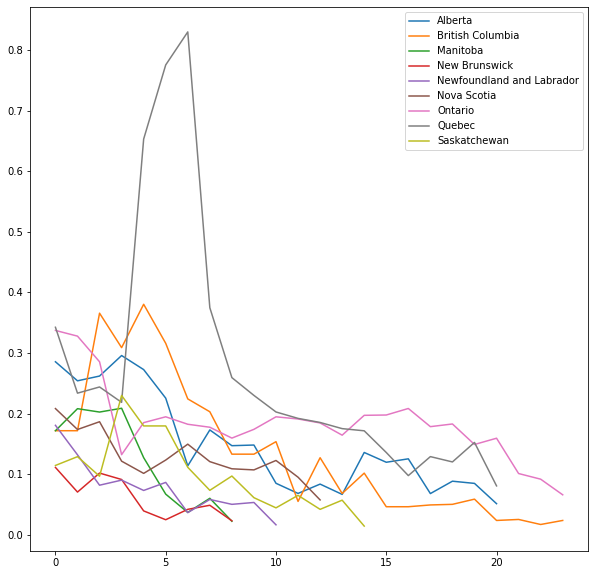

In [17]:
from math import pow
cdn_growth = {}

gdf = df
for c in gdf.columns:
    cdn_growth[c]=[]
    for i in range(3,len(gdf[c])):        
        if not np.isnan(gdf[c][i] and gdf[c][i]>2000):                          
            cdn_growth[c].append(pow(gdf[c][i]/gdf[c][i-3],1.0/3)-1.0)
            
fig,ax = plt.subplots()
for c in cdn_growth:
    ax.plot(cdn_growth[c])
ax.legend(cdn_growth.keys())

In [18]:
# US and Canada 
df=raw
# temporarily drop 03/14
#del df[df.columns[-1]]
df = df[df['Country/Region'].isin(['Canada','US','Italy'])]

df=df.groupby('Country/Region').sum()


df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)


df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
df

,Canada,Italy,US
date,,,
2020-01-22,0,0,1
2020-01-23,0,0,1
2020-01-24,0,0,2
2020-01-25,0,0,2
2020-01-26,1,0,5
...,...,...,...
2020-04-04,12978,124632,308850
2020-04-05,15756,128948,337072
2020-04-06,16563,132547,366667


In [19]:
#https://stackoverflow.com/questions/54376900/fit-sigmoid-curve-in-python

from scipy.optimize import curve_fit
import numpy as np
from scipy.optimize import differential_evolution
import warnings

yData = df['US']
xData = range(len(yData))

def sigmoid(x, amplitude, x0, k):
    return amplitude**2/(1.0+np.exp(-(x-k)/x0))


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = sigmoid(xData, *parameterTuple)
    return np.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minY**2, maxY**2]) # search bounds for amplitude
    parameterBounds.append([1.0/maxX, 1e6]) # search bounds for x0
    parameterBounds.append([minX, maxX]) # search bounds for k

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x, np.array(parameterBounds).T

# by default, differential_evolution completes by calling curve_fit() using parameter bounds
geneticParameters, bounds = generate_Initial_Parameters()
print(geneticParameters)
# now call curve_fit without passing bounds from the genetic algorithm,
# just in case the best fit parameters are aoutside those bounds
popt, pcov = curve_fit(sigmoid, xData, yData, geneticParameters, bounds=[[0,0,0],[np.inf,np.inf,np.inf]],maxfev=10000)
sigma = np.sqrt(np.diag(pcov)) 
print('Fitted parameters: {} Cov: {} Sigma: {}'.format(popt, pcov,sigma))
print()

modelPredictions = sigmoid(xData, *popt) 

absError = modelPredictions - yData

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(yData))

print()
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

xModel = np.linspace(min(xData), min(xData)+90)



[ 307.36885071 1401.88195067   36.6321784 ]
Fitted parameters: [753.17863116   4.50330997  72.18013124] Cov: [[3.30525787e+01 2.99525763e-01 8.94576621e-01]
 [2.99525763e-01 3.41557712e-03 8.31255729e-03]
 [8.94576621e-01 8.31255729e-03 2.48509353e-02]] Sigma: [5.74913722 0.05844294 0.15764179]


RMSE: 2388.3446999674015
R-squared: 0.9994854253162558


In [20]:
# estimate the uncertainty range of the parameters.
L=np.linalg.cholesky(pcov).T
print(popt)
print(L)
eps = 1
[popt-L.dot([eps,0,0]),
 popt+L.dot([eps,0,0]),
 popt-L.dot([0,eps,0]),
 popt+L.dot([0,eps,0]),
 popt-L.dot([0,0,eps]),
 popt+L.dot([0,0,eps])]

# note we use epsilon = 0.5 instead of 1 stanard deviation. 
# The true distribution is asymmetric and heavy-tailed, so we end up with bad estimates for the amplitude.

[753.17863116   4.50330997  72.18013124]
[[5.74913722 0.05209925 0.15560189]
 [0.         0.02648103 0.00777216]
 [0.         0.         0.0240537 ]]


[array([747.42949394,   4.50330997,  72.18013124]),
 array([758.92776838,   4.50330997,  72.18013124]),
 array([753.1265319 ,   4.47682894,  72.18013124]),
 array([753.23073041,   4.529791  ,  72.18013124]),
 array([753.02302927,   4.49553781,  72.15607754]),
 array([753.33423305,   4.51108213,  72.20418494])]

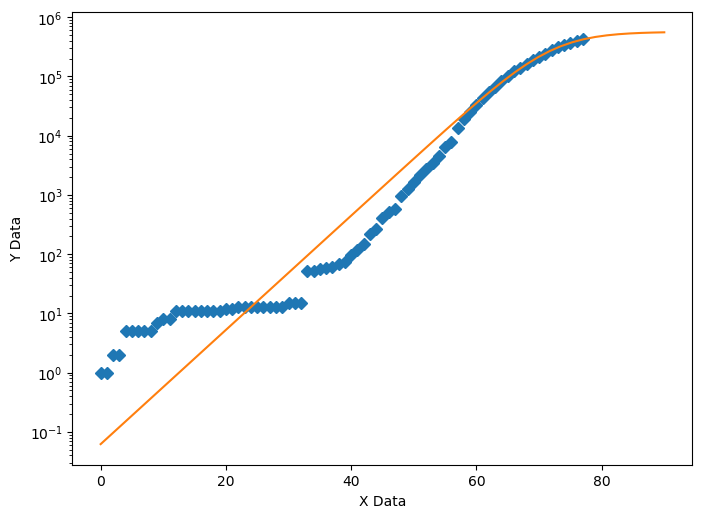

In [21]:
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot    
    yModel = sigmoid(xModel, *popt)

    # now the model as a line plot
    axes.plot(xModel, yModel)
    axes.set_yscale('log')
    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

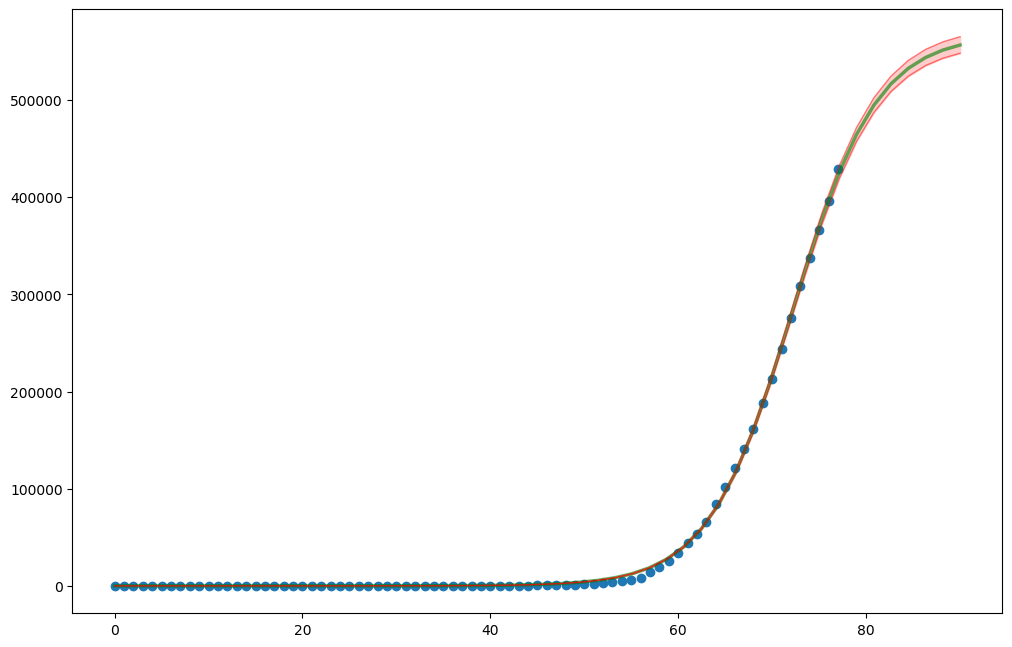

In [22]:
# Plot the best fit sigmoid and uncertainty region.

fig = plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
curveFit = sigmoid(xData,*popt)
curveFitModel = sigmoid(xModel,*popt)
plt.plot(xData, yData, 'o')
#plt.hold(True)
plt.plot(xModel, curveFitModel, 
    linewidth=2.5, 
    color = 'green',
    alpha = 0.6) #,
    #label = fitEquation)

maxes = None
mins = None

for p in [ [0,eps,0], [eps,0,0], [0,0,eps]]:
    params = popt+L.dot(p)
    s= sigmoid(xModel,*params)
    #plt.plot(xModel, s, linewidth= 1.0, alpha = 0.5, color='red')
    if maxes is None:
        maxes = s
    if mins is None:
        mins =s
    maxes = np.maximum(maxes,s)
    mins = np.minimum(mins,s)
    #print(maxes,mins)
    params = popt-L.dot(p)
    #params[0] = max(params[0],max(yData))   # fudge in case the amplitude is negative. 
    s= sigmoid(xModel,*params)
    #plt.plot(xModel, s, linewidth= 1.0, alpha = 0.5, color='red')
    maxes = np.maximum(maxes,s)
    mins = np.minimum(mins,s)

plt.plot(xModel, maxes, linewidth= 1.0, alpha = 0.5, color='red')
plt.plot(xModel, mins, linewidth= 1.0, alpha = 0.5, color='red')
    
plt.fill_between(xModel, mins, maxes, color='#FFcccc')
#ax.set_yscale('log')
#plt.plot(xModel, sigmoid(xModel,lower[0], lower[1], lower[2] ), #curveFitModel-fitError, 
#    linewidth = 1.0, 
#    alpha = 0.5, 
#    color = 'red')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
#plt.text(3.2, 1.0, 
#    ("$\mathrm{curve fit\;\;values:\;}$\n a = %.3f\t $\pm$ %.3f\n b = %.3f\t $\pm$ %.3f \n c = %.3f\t $\pm$ %.3f" 
#    % (popt[0], sigma[0], popt[1], sigma[1], popt[2], sigma[2])), fontsize=16,bbox=props )
#xlabel(r'\textrm{time (s)}', fontsize=24)
#ylabel(r'\textrm{temperature (K)}',fontsize=24)
#plt.title(r"Exponential fit with $\pm 1\sigma$ and $\pm 3\sigma$ fit errors",
#      fontsize=28, color='k')
#ax.legend(fontsize=18)
#plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('3sigmaPlot.pdf', figsize=(6,4), dpi=600)
#plt.show()

[[19, 20, 20, 20, 20, 21, 21, 22, 21, 21, 21, 21, 21, 22, 22, 23, 23, 24, 23, 25], [11, 11, 11, 11, 12, 11, 11, 12, 11, 11, 11, 11, 11, 10, 10, 10, 9, 8, 7, 7, 7, 6, 6, 5, 5, 4, 4, 3, 3, 2, 2, 1, 0, 0, -1, -2, -2, -3, -4, -5, -6, -6, -7, -8, -9, -10]]


Text(0, 0.5, 'Country reached X cases Y days after Italy')

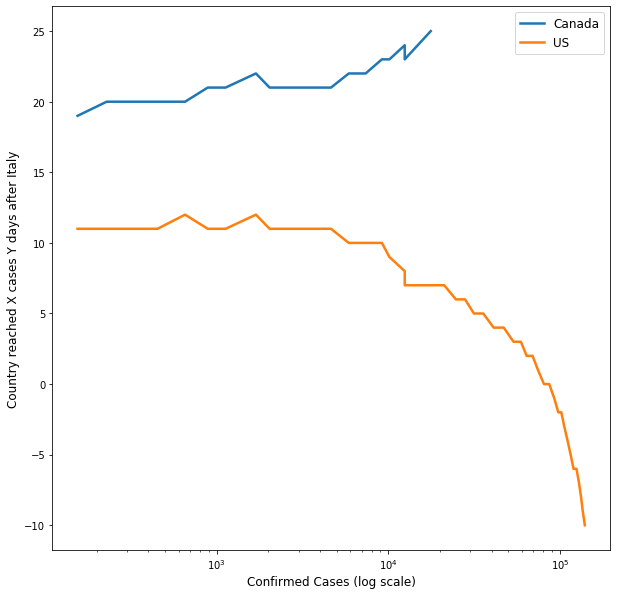

In [23]:
deltas = [[],[]]
vals = []
for i,v in enumerate(df['Italy']):
    if v<100:
        continue
    vals.append(v)
    for j,v2 in enumerate(df['Canada']):            
        if v2>=v:
            deltas[0].append(j-i)
            break
    for j,v2 in enumerate(df['US']):
        if v2>=v:
            deltas[1].append(j-i)
            break
print(deltas)
fig, ax = plt.subplots()
#ax.plot(zip(vals,deltas[0]))

ax.plot(vals[:len(deltas[0])],deltas[0], linewidth=2.5)
ax.plot(vals[:len(deltas[1])],deltas[1], linewidth=2.5)
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
ax.legend(['Canada','US'], prop=font)
ax.set_xscale('log')
ax.set_xlabel('Confirmed Cases (log scale)', size=12)
ax.set_ylabel('Country reached X cases Y days after Italy', size=12)

Text(0, 0.5, 'Confirmed cases')

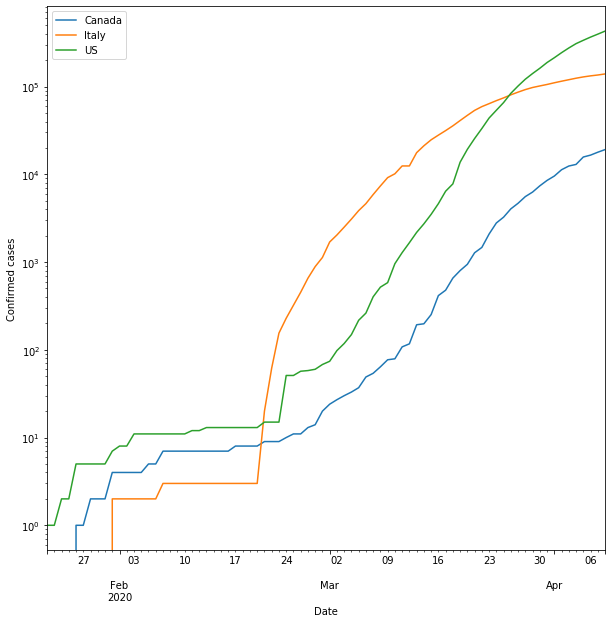

In [24]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10]

ax=df.plot(legend=True,logy=True) #list(df.columns))
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed cases')


In [25]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df = df[(df.index.isin(['Mexico']))]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
df

,Mexico
date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-04-04,1688
2020-04-05,1890
2020-04-06,2143


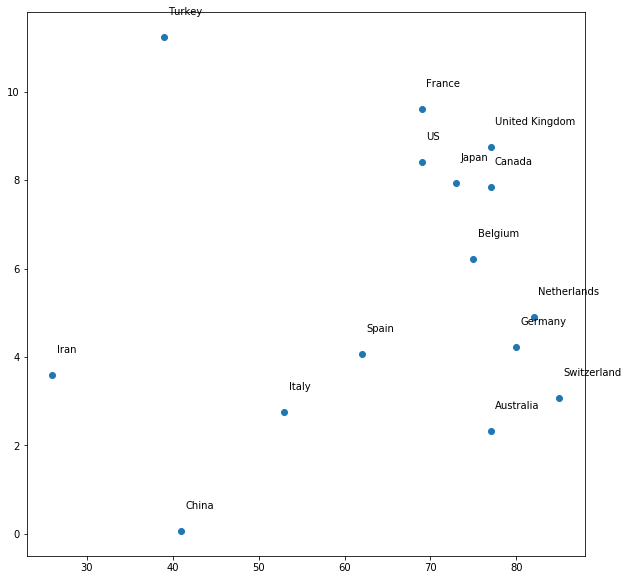

In [26]:
cpi = pd.read_csv('../cpi/cpi.tsv',sep='\t')
cpi = dict(zip(cpi['Country'],cpi['CPI score 2019']))
cpi
check = [c for c in growth if c not in cpi]
cpi['US'] = cpi['United States of America']

x= [cpi[c] for c in growth]
y = [growth[c][-1] for c in growth]
fig, ax = plt.subplots()
ax.scatter(x, y)
for i, txt in enumerate(growth):
    ax.annotate(txt, (x[i]+0.5,y[i]+0.5))

In [27]:
df=raw
# temporarily drop 03/14
#del df[df.columns[-1]]
#df = df[df['Country/Region'].isin(['Canada','US','Italy'])]

df=df.groupby('Country/Region').sum()


df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)


df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]

matrix = {}

for c in sorted(df.columns, key=lambda c: df[c][-1], reverse=True):
    if max(df[c])<1000:
        continue
    matrix[c]={}
    last1 = df[c][-1]
    for c2 in sorted(df.columns, key=lambda c: df[c][-1], reverse=True):
        if max(df[c2])<1000:
            continue
        if c2==c:
            matrix[c][c2]=0
            continue
        last2 = df[c2][-1]
        if last2<=last1:
            for j,v2 in enumerate(df[c]):            
                if v2>=last2:
                    matrix[c][c2]=len(df[c])-j-1
                    break
        else:
            for j,v2 in enumerate(df[c2]):            
                if v2>=last1:
                    matrix[c][c2]=-(len(df[c2])-j-1)
                    break
result=pd.DataFrame.from_dict(matrix)
result.to_csv('lagtimes.tsv', sep='\t')

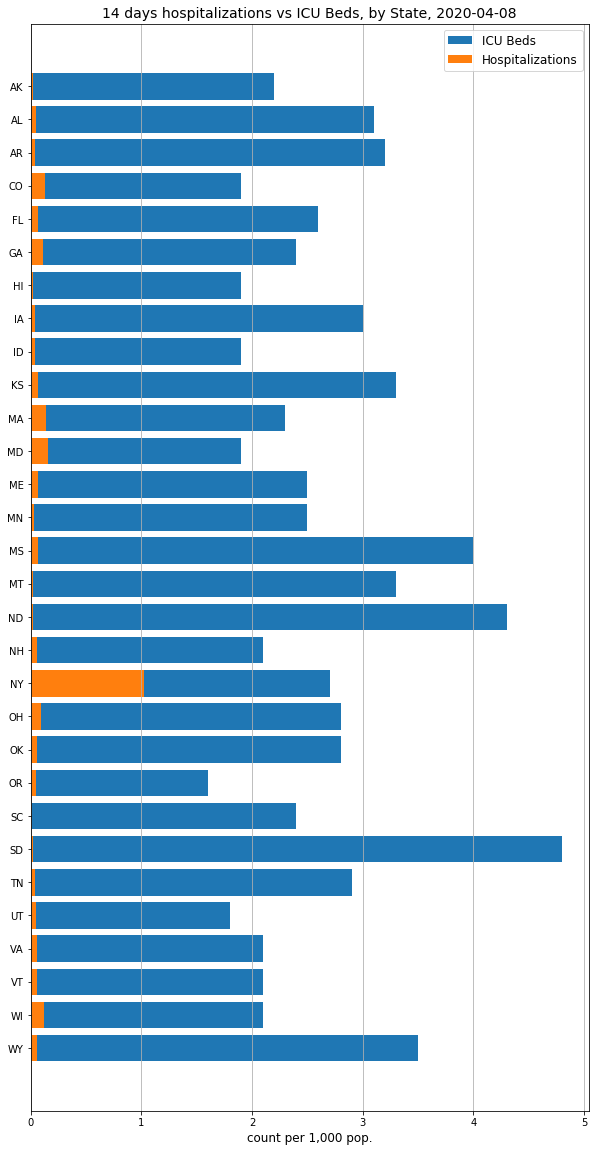

In [28]:
from datetime import datetime
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
offset = 14  # assuming hopitalizations happen later than confirmation.
#confirmed = covidtracking.pivot(index='date',columns='state', values='positive')
#confirmed = confirmed.replace(np.nan,0)
hospitalized = covidtracking.pivot(index='date',columns='state', values='hospitalized')
hospitalized = hospitalized[sorted([c for c in hospitalized.columns if hospitalized[c].notna()[-1]],reverse=True)]
hospitalized = hospitalized.replace(np.nan,0)

df=hospitalized
deaths = covidtracking.pivot(index='date',columns='state', values='death')
deaths = deaths.replace(np.nan,0)
icu = pd.read_csv('../other3p/icu.csv',skiprows=2)
statecodes = pd.read_csv('../expdev07/statecodes.tsv', sep='\t',names=['Abbrev','State'])
statecodes = dict(zip(statecodes['State'],statecodes['Abbrev']))
index = [statecodes[c] if c in statecodes else None for c in icu['Location']]
icu = dict([(l,t) for (l,t) in zip(index,icu['Total'])])

pop = pd.read_csv('../other3p/state_pop.txt', sep='\t', names=['State','Pop'])
pop = dict(zip([statecodes[c.replace('.','')] for c in pop['State']],pop['Pop']))
#icu
cols = [c for c in df.columns if c in icu]
data = list(zip(cols, [max(0,df[c][-1]-df[c][-offset]-(deaths[c][-1]-deaths[c][-offset]))*1e3/pop[c] for c in cols], [icu[c] for c in cols]))

plt.rcParams["figure.figsize"] = [10, 20]
fig, ax = plt.subplots()
labels = [c for (c,_,_) in data]
ax.grid(b=True,axis='x')
ax.barh(labels, [x for (_,_,x) in data])
ax.barh(labels, [x for (_,x,_) in data])
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
#ax.title('Per state estimated active cases vs ICU beds.')
ax.legend(['ICU Beds','Hospitalizations'], prop=font)
ax.set_title('14 days hospitalizations vs ICU Beds, by State, {}'.format(datetime.strftime(maxDate,'%Y-%m-%d')),size=14)
ax.set_xlabel('count per 1,000 pop.', size=12)
# Stop exporting this. It doesn't seem correct.
#save_figure(maxDate,'13_icubeds.png')

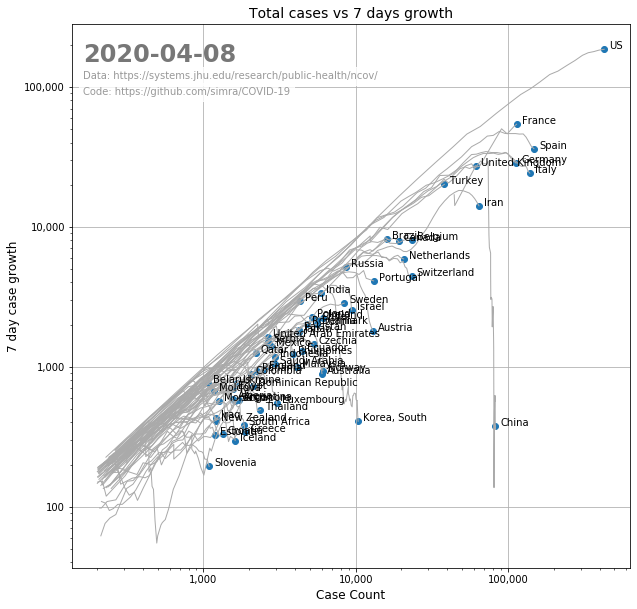

In [29]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>1000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate=max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []
markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
start = 20
for c,m in zip(df.columns,markers):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-6] if df[c][i]>200 else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(df[c][start:], growth[c], linewidth=1,color='#aaaaaa')
    points.append([df[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('Case Count', size=12)
ax.set_ylabel('7 day case growth', size=12)
ax.set_title('Total cases vs 7 days growth', size=14)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'10_countvsgrowth.png')

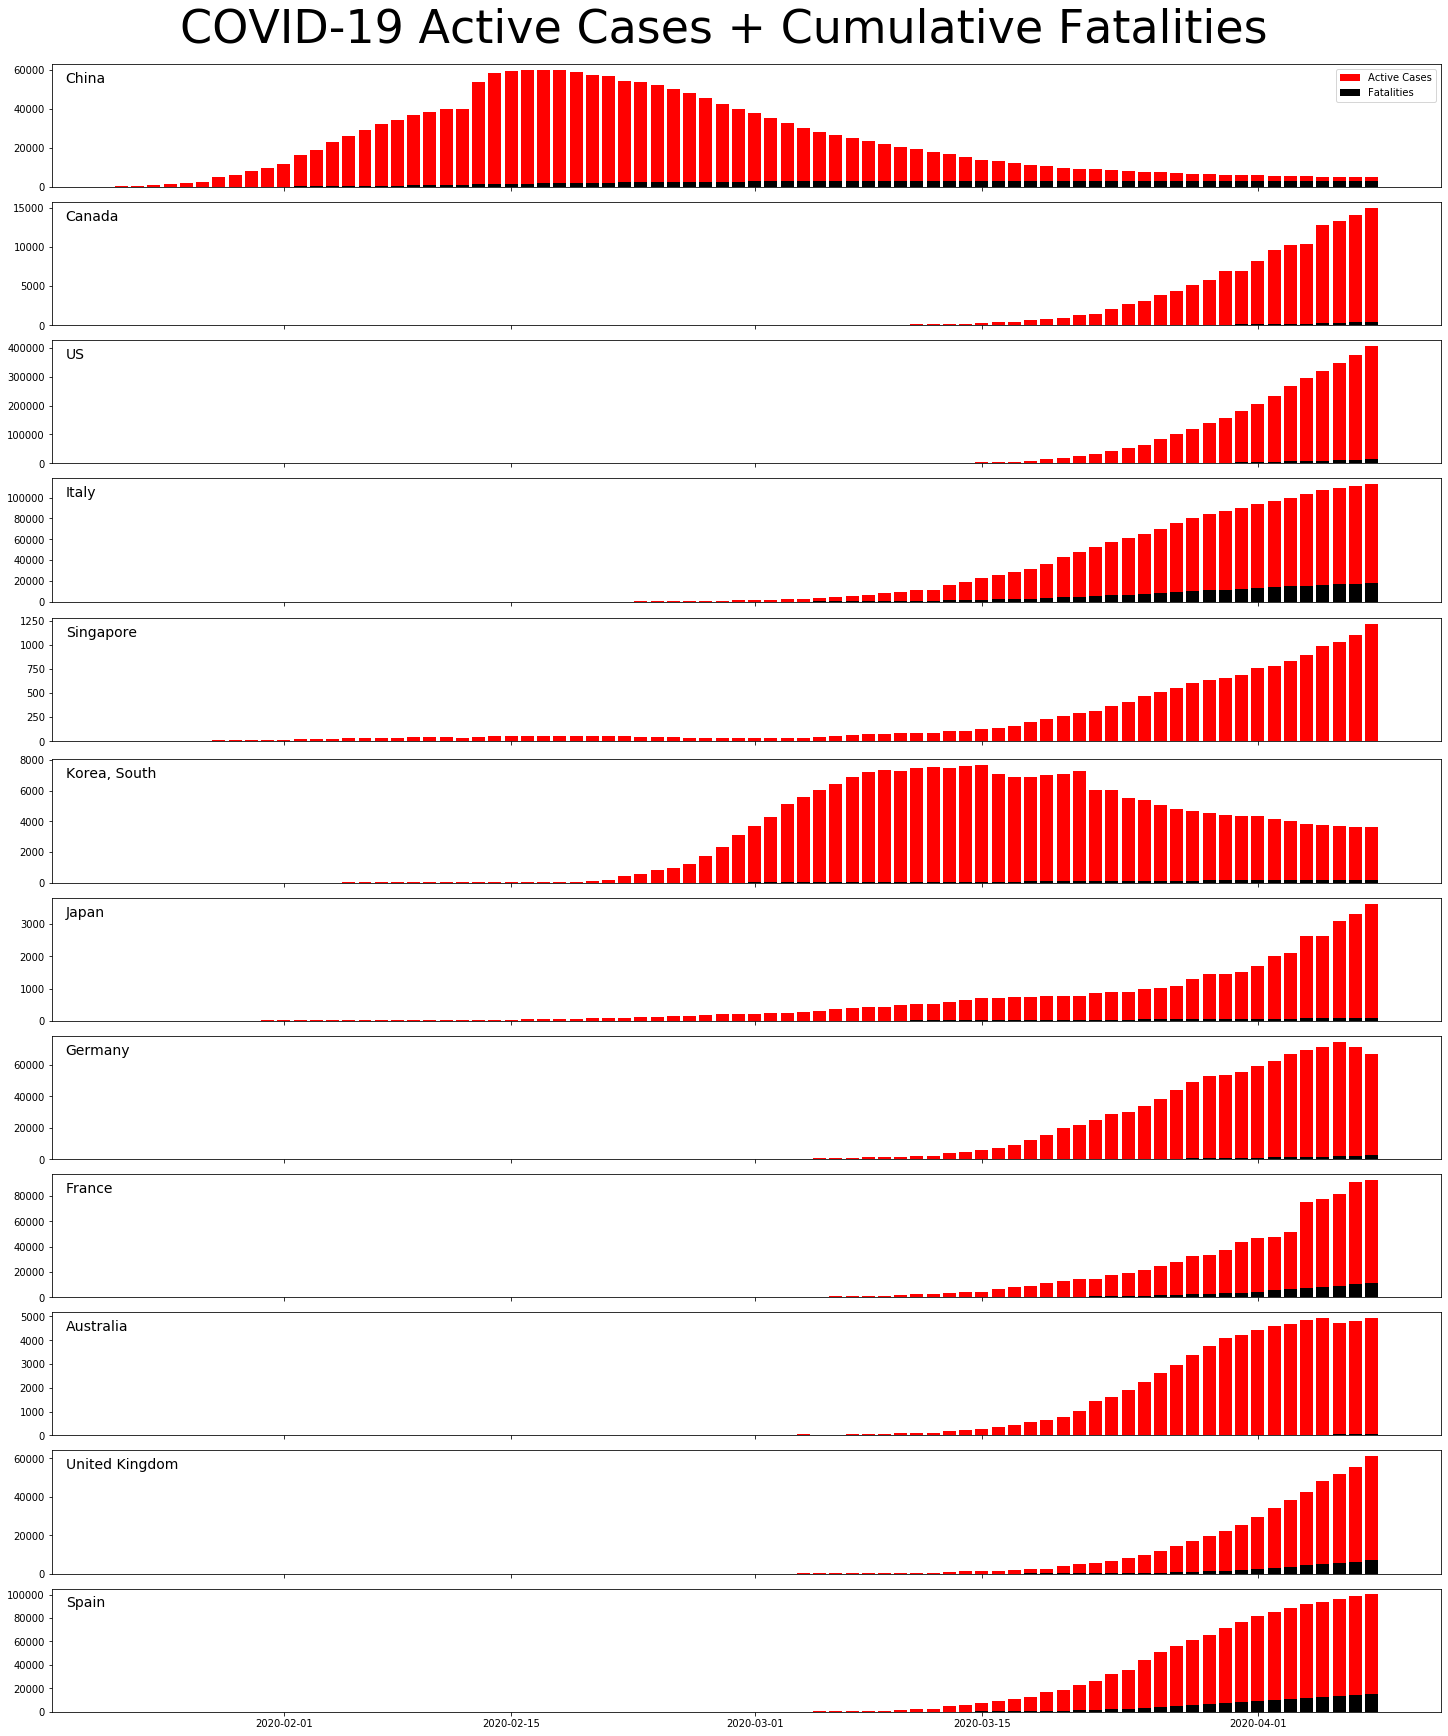

In [30]:


def prepData(datapath):
    raw = pd.read_csv(datapath)
    del raw['Lat']
    del raw['Long']
    raw= raw.replace('Mainland China','China')
    df=raw.groupby('Country/Region').sum()
    # 03/14: temporarily drop the last column
    #del df[df.columns[-1]]
    last_date = list(df.columns)[-1]

    #df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>100)]

    df['Country/Region']=df.index
    df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
    df['date']=pd.to_datetime(df.index)

    df.index.name = None
    df=df.sort_values(by=['date'])
    df.set_index('date', inplace=True)
    df.columns = [c[1] for c in df.columns]
    return df

deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')


def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        active = []
        for (c,r,d) in zip(confirmed[country], recovered[country], deaths[country]):
            active.append(c-r) # don't subtract deaths because we want this to stack.
        #if country=='Canada':
        #print(active,confirmed[country])
        ax.bar(confirmed.index,active, color='red')
        rec = []
        for (r,d) in zip(recovered[country],deaths[country]):
            rec.append(r+d)        
        #ax.bar(recovered.index,rec, color='green')
        ax.bar(deaths.index, deaths[country], color='black')
        #ax.set_yscale('log')
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=14)
        fig.suptitle('COVID-19 Active Cases + Cumulative Fatalities',size=46)
        if i==0:
            ax.legend(['Active Cases','Fatalities'])


plotBars(['China','Canada','US','Italy','Singapore','Korea, South','Japan','Germany','France','Australia','United Kingdom','Spain'])

maxDate = confirmed.index[-1]
#print(maxDate)
save_figure(maxDate,'5_barplots.png')

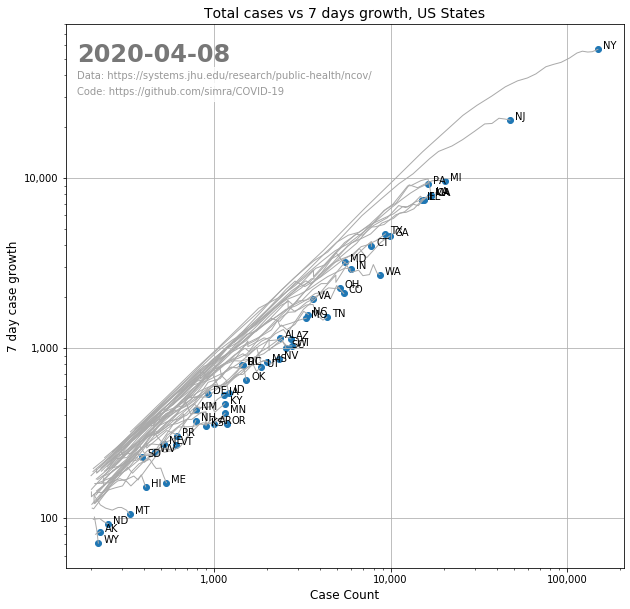

In [31]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
df = covidtracking.pivot(index='date',columns='state', values='positive')
#df = df[[c for c in df.columns if df[c].max()>1000]]

maxDate=max(df.index)
plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []

markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
growth = {}
start = 7
for c,m in zip(df.columns,markers):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-6] if df[c][i]>200 else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(df[c][start:], growth[c], linewidth=1,color='#aaaaaa')
    points.append([df[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('Case Count', size=12)
ax.set_ylabel('7 day case growth', size=12)
ax.set_title('Total cases vs 7 days growth, US States', size=14)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))


save_figure(maxDate,'11_usstatesgrowth.png')

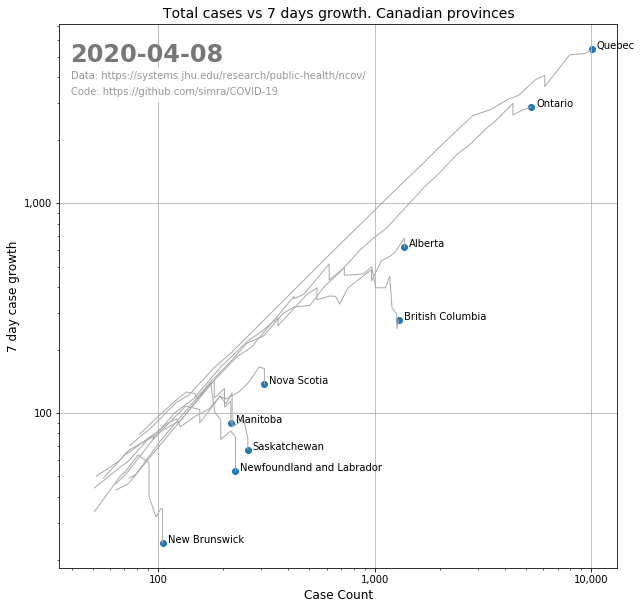

In [32]:
df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
threshold=50
df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Province/State']=df.index
df=df.melt(id_vars='Province/State',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province/State')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

maxDate = max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []

markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
growth = {}
start = 7
for c,m in zip(df.columns,markers):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-7] if df[c][i]>threshold else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(df[c][start:], growth[c], linewidth=1,color='#aaaaaa')
    points.append([df[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Total cases vs 7 days growth. Canadian provinces', size=14)
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('Case Count', size=12)
ax.set_ylabel('7 day case growth', size=12)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))


save_figure(maxDate,'12_canadagrowth.png')


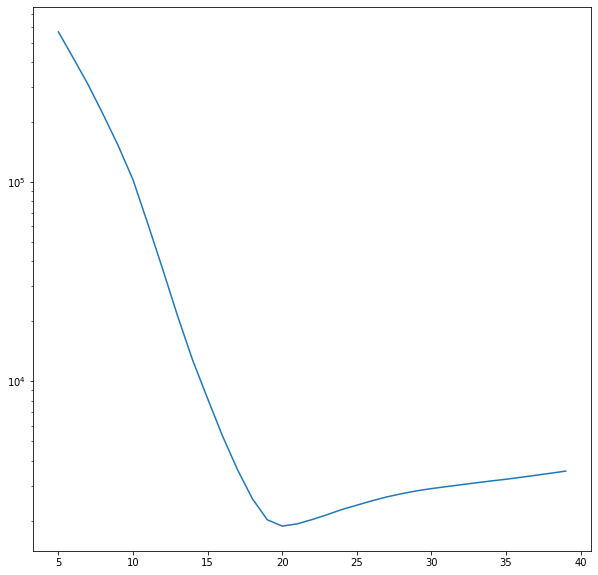

In [33]:
def prepData(datapath):
    raw = pd.read_csv(datapath)
    del raw['Lat']
    del raw['Long']
    raw= raw.replace('Mainland China','China')
    df=raw.groupby('Country/Region').sum()
    # 03/14: temporarily drop the last column
    #del df[df.columns[-1]]
    last_date = list(df.columns)[-1]

    #df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>100)]

    df['Country/Region']=df.index
    df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
    df['date']=pd.to_datetime(df.index)

    df.index.name = None
    df=df.sort_values(by=['date'])
    df.set_index('date', inplace=True)
    df.columns = [c[1] for c in df.columns]
    return df

deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

def predict(c, offset):
    start = offset
    predictions = []
    actual = []
    for i in range(start,len(confirmed[c])):
        actual.append(recovered[c][i])
        predictions.append(confirmed[c][i-offset]-deaths[c][i])
    return list(zip(predictions,actual))

def error(series):
    return sum([(p/max(a,1)-1)**2 for (p,a) in series])/len(series)

def global_error(offset):
    return sum([error(predict(c,offset)) for c in confirmed.columns ])

results = [(x,global_error(x)) for x in range(5,40)]
fig, ax = plt.subplots()
ax.plot([r[0] for r in results], [r[1] for r in results])
ax.set_yscale('log')
    #print(x,global_error(x))


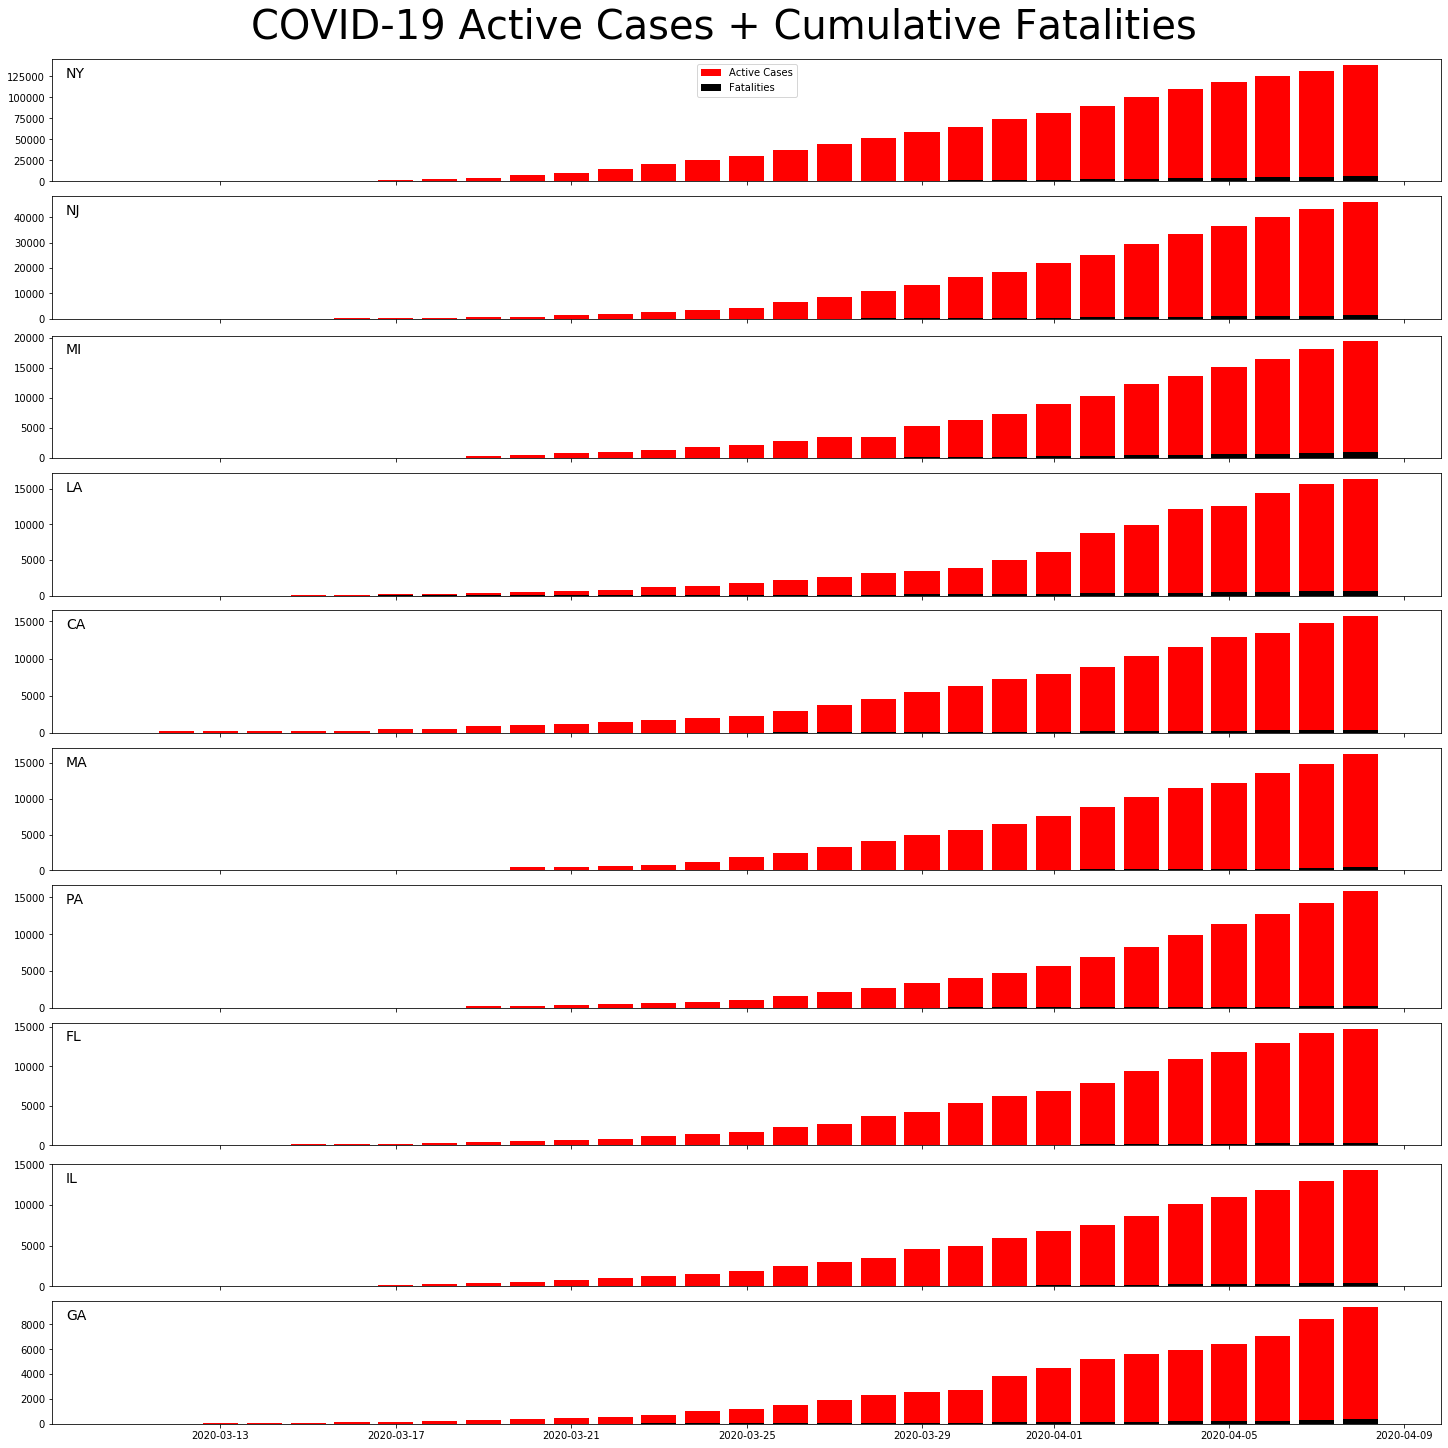

In [34]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
confirmed = covidtracking.pivot(index='date',columns='state', values='positive')
deaths = covidtracking.pivot(index='date',columns='state', values='death')
offset = 18

#df = df[[c for c in df.columns if df[c].max()>1000]]

maxDate=max(df.index)


def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        recovered = [0 if j-offset<0 else max(0,confirmed[country][j-offset]-deaths[country][j]) for j in range(0,len(confirmed[country]))]
        active = []
        for (c,r,d) in zip(confirmed[country], recovered, deaths[country]):
            active.append(c-r-d)
        ax.bar(confirmed.index,active, color='red')
        #ax.bar(confirmed.index,recovered, color='red')
        rec = []
        #for (r,d) in zip(recovered,deaths[country]):
        #    rec.append(r+d)
        #ax.bar(recovered.index,rec, color='green')
        ax.bar(deaths.index, deaths[country], color='black')
        #ax.set_yscale('log')
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=14)
        fig.suptitle('COVID-19 Active Cases + Cumulative Fatalities',size=40)
        if i==0:
            ax.legend(['Active Cases','Fatalities'], loc='upper center')

statesToPlot = sorted(confirmed.columns, key=lambda c: max(confirmed[c].fillna(0)), reverse=True)[:10]

#plotBars(['WA','NY','CA','NJ','MA','LA','FL'])
plotBars(statesToPlot)

maxDate = confirmed.index[-1]
#print(maxDate)
save_figure(maxDate,'16_usbarplots.png')

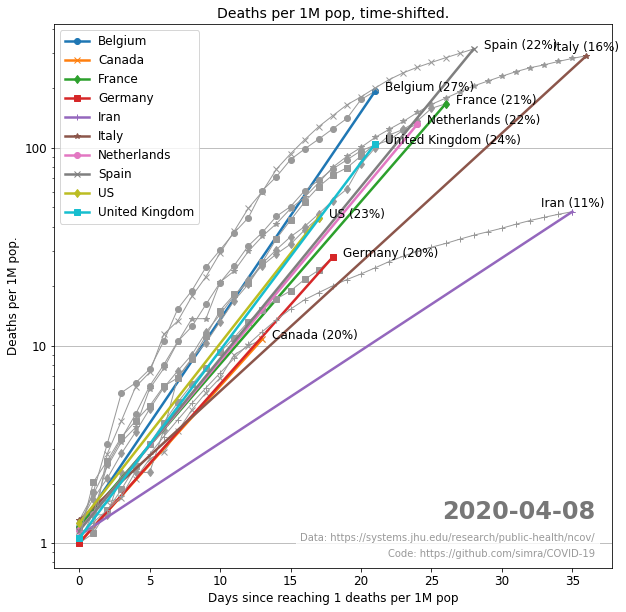

In [35]:
# Try normalizing by population
# https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv
wpp = pd.read_csv('../wpp/WPP2019_TotalPopulationBySex.csv')
wpp=wpp[(wpp['Time']==2020) & (wpp['Variant']=='Medium')]
wpp = dict(zip(wpp['Location'],wpp['PopTotal']))
wpp['Iran']=wpp['Iran (Islamic Republic of)']
wpp['US']=wpp['United States of America']
wpp['Korea, South']= wpp['Republic of Korea']
wpp['Russia'] = wpp['Russian Federation']

df=raw_deaths.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

    
df = df[[c for c in df.columns if df[c].max()>1000 or c in ['Canada','US']]] #, 'Australia', 'Czechia'
for c in df.columns:
    df[c] = df[c]*1000/wpp[c]
df = df[[c for c in df.columns if df[c].max()>10 or c in ['Canada','US']]] #, 'Australia', 'Czechia'

#plotdataframe(df, logy=True)
maxDate = max(df.index)
threshold = 1
df= shift(df,threshold=threshold)

ax=plotdataframe_point(df, logy=True, title='Deaths per 1M pop, time-shifted.')
ax.set_xlabel("Days since reaching {} deaths per 1M pop".format(threshold), size=12)
ax.set_ylabel("Deaths per 1M pop." , size=12)
ax.grid(axis='y')
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'14_countryshift_norm-deaths.png')

#wpp

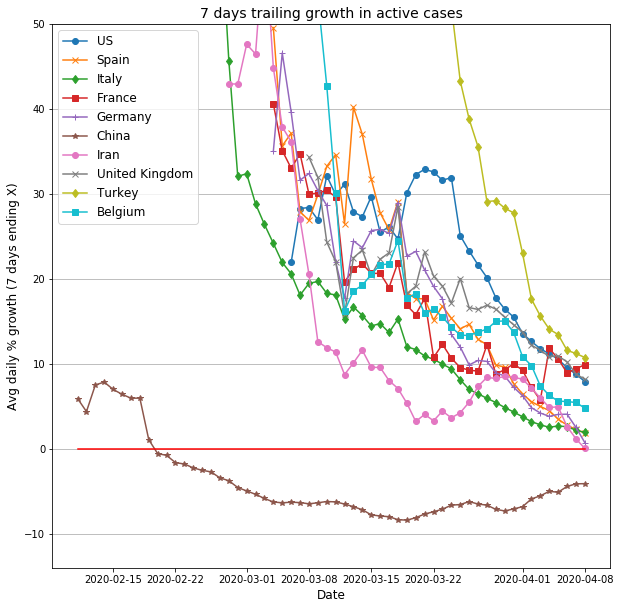

In [36]:
deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

columnsToSelect = sorted(confirmed.columns, key=lambda c: max(confirmed[c]), reverse=True)[:10]
#confirmed = confirmed[[c for c in confirmed.columns if max(confirmed[c])>10000]]
confirmed = confirmed[columnsToSelect]


def active(c):
    start = offset
    active = []
    for i in range(0,len(confirmed[c])):
        val = confirmed[c][i]-recovered[c][i]-deaths[c][i]
        if val<0: 
            print(c,confirmed[c][i], recovered[c][i], deaths[c][i])
        active.append(confirmed[c][i]-recovered[c][i]-deaths[c][i])        
    return active#del df['Cruise Ship']

maxDate=max(confirmed.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
markers = [item for sublist in ['oxds+*']*ceil(len(confirmed.columns)/5) for item in sublist]    
for c,m in zip(confirmed.columns,markers):  
    active_cases = active(c)
    growth[c] = [(pow(active_cases[i]/max(1.0,active_cases[i-6]),1.0/7)-1)*100 if active_cases[i]>200 else float('nan') for i in range(20,len(confirmed[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(confirmed.index[20:], growth[c], marker=m)

ax.plot(confirmed.index[20:], [0]*len(confirmed.index[20:]),color='#ff0000')
    
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)

ax.set_title('7 days trailing growth in active cases', size=14)
ax.grid(axis='y') 
#ax.yaxis.set_label_position("right")
lims=ax.get_ylim()
ax.set_ylim([lims[0],50])
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Avg daily % growth (7 days ending X)', size=12)
ax.legend(confirmed.columns, prop=font)    
#plt.ylim((0,100))
save_figure(maxDate,'14_growthvsactive.png')

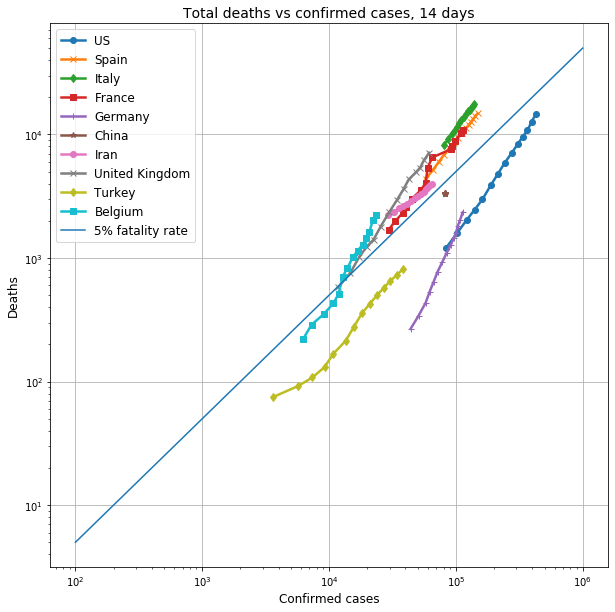

In [37]:
deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

columnsToSelect = sorted(confirmed.columns, key=lambda c: max(confirmed[c]), reverse=True)[:10]
#confirmed = confirmed[[c for c in confirmed.columns if max(confirmed[c])>10000]]
confirmed = confirmed[columnsToSelect]
deaths = deaths[[c for c in confirmed.columns]]

maxDate=max(confirmed.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
markers = [item for sublist in ['oxds+*']*ceil(len(confirmed.columns)/5) for item in sublist]    
for c,m in zip(confirmed.columns,markers):  
    ax.plot(confirmed[c][-14:],deaths[c][-14:], marker=m, linewidth=2.5)

ax.plot([100,1e6],[5,5e4])
    
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Confirmed cases', size=12)
ax.set_ylabel('Deaths', size=12)
ax.set_title('Total deaths vs confirmed cases, 14 days', size=14)
ax.legend(list(confirmed.columns)+['5% fatality rate'], prop=font)    
save_figure(maxDate,'15_deathsvsconfirmed.png')

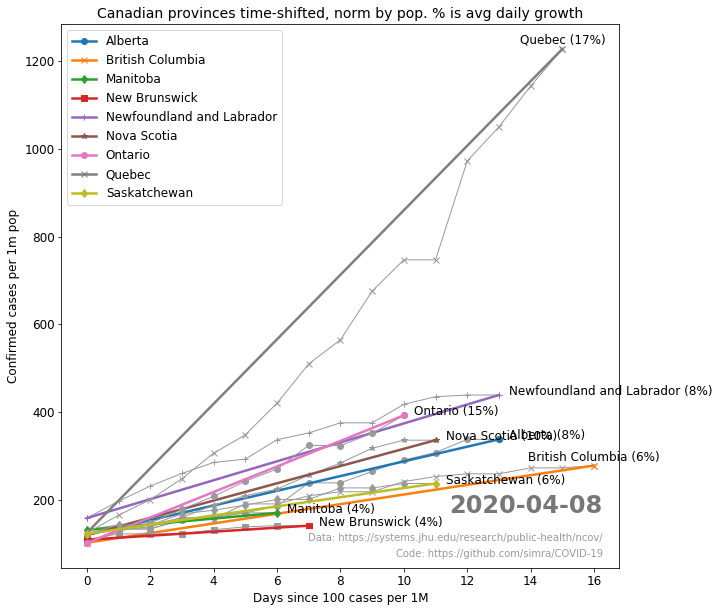

In [38]:
# 2016 census
canadapop = {
 'Ontario': 13448494,
 'Quebec': 8164361,
 'British Columbia': 4648055,
 'Alberta': 4067175,
 'Manitoba': 1278365,
 'Saskatchewan': 1098352,
 'Nova Scotia': 923598,
 'New Brunswick': 747101,
 'Newfoundland and Labrador': 519716,
 'Prince Edward Island': 142907,
 'Northwest Territories': 41786,
 'Nunavut': 35944,
 'Yukon': 35874

}

df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
threshold=50
df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Province/State']=df.index
df=df.melt(id_vars='Province/State',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province/State')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

for c in df.columns:
    df[c] = df[c]*1e6/canadapop[c]
        
threshold = 100
maxDate = max(df.index)
df=shift(df,threshold)
df
# TODO: change to log plot if these grow > 1
ax=plotdataframe_point(df, logy=False, legend_loc='upper left', title='Canadian provinces time-shifted, norm by pop. % is avg daily growth')
ax.set_xlabel('Days since {} cases per 1M'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases per 1m pop', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '16_canada_normalized.png')

{'AL': 4903185, 'AK': 731545, 'AZ': 7278717, 'AR': 3017804, 'CA': 39512223, 'CO': 5758736, 'CT': 3565287, 'DE': 973764, 'DC': 705749, 'FL': 21477737, 'GA': 10617423, 'HI': 1415872, 'ID': 1787065, 'IL': 12671821, 'IN': 6732219, 'IA': 3155070, 'KS': 2913314, 'KY': 4467673, 'LA': 4648794, 'ME': 1344212, 'MD': 6045680, 'MA': 6892503, 'MI': 9986857, 'MN': 5639632, 'MS': 2976149, 'MO': 6137428, 'MT': 1068778, 'NE': 1934408, 'NV': 3080156, 'NH': 1359711, 'NJ': 8882190, 'NM': 2096829, 'NY': 19453561, 'NC': 10488084, 'ND': 762062, 'OH': 11689100, 'OK': 3956971, 'OR': 4217737, 'PA': 12801989, 'RI': 1059361, 'SC': 5148714, 'SD': 884659, 'TN': 6829174, 'TX': 28995881, 'UT': 3205958, 'VT': 623989, 'VA': 8535519, 'WA': 7614893, 'WV': 1792147, 'WI': 5822434, 'WY': 578759} Index(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', '

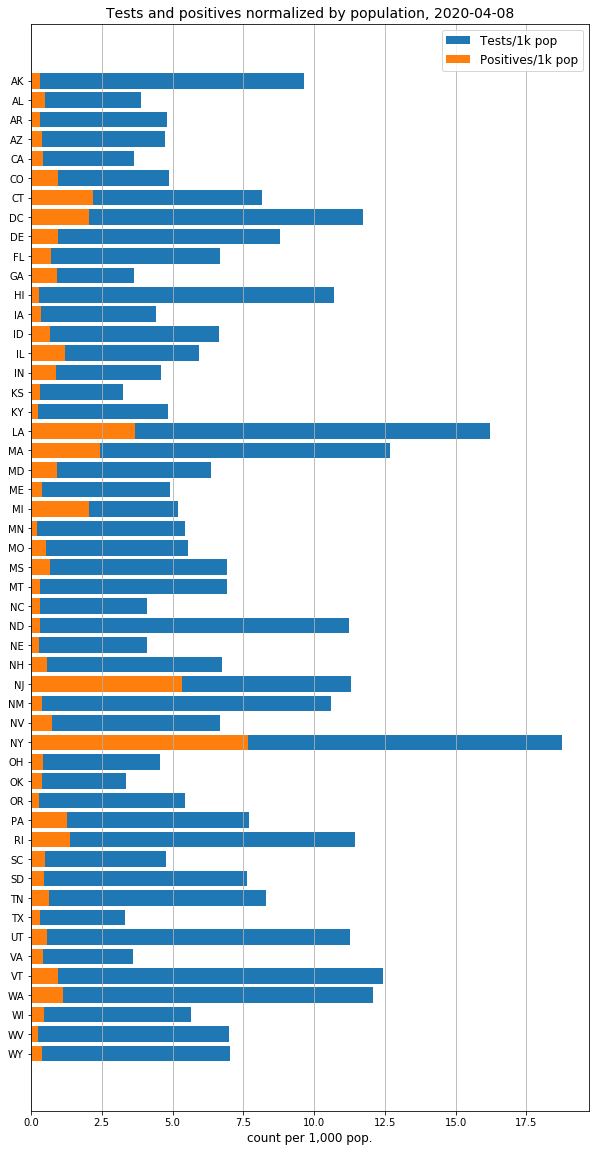

In [39]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
positives = covidtracking.pivot(index='date',columns='state', values='positive')
positives=positives.fillna(0)
negatives = covidtracking.pivot(index='date',columns='state', values='negative')
negatives=negatives.fillna(0)

statecodes = pd.read_csv('../expdev07/statecodes.tsv', sep='\t',names=['Abbrev','State'])
statecodes = dict(zip(statecodes['State'],statecodes['Abbrev']))

pop = pd.read_csv('../other3p/state_pop.txt', sep='\t', names=['State','Pop'])
pop = dict(zip([statecodes[c.replace('.','')] for c in pop['State']],pop['Pop']))
#icu
print(pop,positives.columns)
cols = sorted([c for c in positives.columns if c in pop], reverse=True)
data = list(zip(cols, [max(positives[c])*1e3/pop[c] for c in cols], [max(positives[c]+negatives[c])*1e3/pop[c] for c in cols]))

plt.rcParams["figure.figsize"] = [10, 20]
fig, ax = plt.subplots()
labels = [c for (c,_,_) in data]
ax.grid(b=True,axis='x')
ax.barh(labels, [x for (_,_,x) in data])
ax.barh(labels, [x for (_,x,_) in data])
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
#ax.title('Per state estimated active cases vs ICU beds.')
ax.legend(['Tests/1k pop','Positives/1k pop'], prop=font)
ax.set_title('Tests and positives normalized by population, {}'.format(datetime.strftime(maxDate,'%Y-%m-%d')),size=14)
ax.set_xlabel('count per 1,000 pop.', size=12)
save_figure(maxDate,'17_tests.png')